# Google Tread with Image Gen

In [2]:
# !pip install together
# !pip install -U browser_use

In [3]:
import asyncio
import nest_asyncio

from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from browser_use import Agent, Browser, BrowserConfig
import os
from google import genai
from pydantic import SecretStr
from IPython.display import Markdown, display, update_display, Image
from dotenv import load_dotenv
import requests
from openai import OpenAI
from datetime import datetime
from together import Together
import urllib.request
from diffusers import DiffusionPipeline

import torch
from huggingface_hub import login

nest_asyncio.apply()   
load_dotenv(override=True)

login(os.environ['HF_TOKEN'],
      add_to_git_credential=True)

INFO     [browser_use] BrowserUse logging setup complete with level info
INFO     [telemetry] Anonymized telemetry enabled. See https://docs.browser-use.com/development/telemetry for more information.


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


WARNING  [huggingface_hub._login] Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
use_which_llm = 'google'

#Config for local usage
insturction_llm_base_url = 'http://127.0.0.1:1234/v1'
insturction_model = 'qwen2.5-coder-14b-instruct-mlx'
insturction_reporting_model = 'qwen2.5-14b-instruct-mlx'
insturction_api_key = 'None'

title_llm_base_url = 'http://10.10.10.2:1234/v1'
title_model = 'qwen2.5-14b-instruct-1m'
title_api_key = 'None'

#Config for google LLM
google_api_key = os.getenv('GOOGLE_API_KEY')
google_data_gathering_model = 'gemini-2.0-flash-lite' #Light weight model to gather data
google_reporting_model = 'gemini-2.0-flash-lite' #Can chose a different model for reporting
planner_model =''
# model = "gemini-2.0-flash-lite"
# model = 'gemini-2.5-flash-preview-04-17'

# Config for agents
agent_max_steps = 100 
use_planner_model = False
generate_gif = False

# config browser
headless_mode = True
disable_security = False

initial_actions = []


task = f"""
        you are a web scraper and crawer.
        
        Get the top search tread on https://trends.google.com/trending?geo=SG
        
        using the top search tread, search on google
        scrape data on it.
        
        Be as detailed as possible.
        """

# artist_name_or_studio = 'studio ghibli'


local_system_prompt_task = f""" 
                            Analyst the text and 
                            follow this rules

                            Structure
                                Be specific about the goal: Clearly state what you want to accomplish
                                Break complex tasks into steps: Use numbered lists for multi-step processes
                                Include format specifications: Mention desired output formats and structures
                                Provide context: Include relevant background information the agent needs
                                Set constraints: Specify any limitations or requirements the agent should follow
                            
                            Clarity
                                Use precise language: Avoid ambiguity and vague instructions
                                Specify parameters: Include exact values, ranges, or criteria
                                Clarify expectations: Explain what success looks like
                                Include examples: Provide examples of desired outputs when helpful
                                Define terminology: Explain industry-specific or technical terms
                            
                            Adaptability
                                Include fallback options: Provide alternatives if the primary approach fails
                                Specify error handling: Explain how to deal with potential issues
                                Allow for iteration: Build in opportunities for refinement
                                Request verification: Ask the agent to verify critical information
                                Include decision points: Define how choices should be made when alternatives exist
                            
                            Efficiency
                                Prioritize tasks: Indicate which aspects are most important
                                Set time or resource limits: Specify constraints on depth or breadth
                                Focus on value-add activities: Emphasize where the agent can provide the most value
                                Minimize unnecessary steps: Avoid redundant or low-value activities
                                Batch similar operations: Group related tasks for efficiency

                            Return in markdown
                            """

local_prompt_task = """
                    Analyst the text and Breakdown the task in simple details in details for a webscraper
                    
                    It is very critical that you answer only in a Step-by-Step instruction.
                    Don't include any other verbose explanatiouns 
                    and don't include the markdown syntax anywhere 
                    
                    and be very detailed:
                    """

local_prompt_task += task

image_prompt_contents = f"""
                find me a something interesting in the text and 
                Write me a short prompt 
                that can be use as a image prompt generator
                
                return in markdown, only return the image prompt and no comments.
                Based on the extracted data below:
            """

summery_prompt_contents = f"""
                Write me a short Paragraph

                return in markdown, 
                Based on the extracted data below:
            """

title_prompt_contents = f"""
                Get the tread title

                return in markdown, only return the trend title and no comments.
                Based on the extracted data below:
            """
date_today = datetime.today().strftime('%Y-%m-%d')

In [5]:
def get_prompt_instruction(local_prompt_task, local_system_prompt_task, model, base_url, api_key):
    openai = OpenAI(base_url=base_url, api_key=api_key)
    
    messages = [
    {"role": "system",
     "content": local_system_prompt_task,
    "role": "user",
     "content": local_prompt_task}]

    response = openai.chat.completions.create(
            model = model,
            messages = messages,
            temperature = 0.2,
            top_p = 0.1
        )
    
    return response.choices[0].message.content

In [6]:
instruction_prompt_gather_data = get_prompt_instruction(local_prompt_task, 
                                            local_system_prompt_task, 
                                            model=insturction_model, 
                                            base_url=insturction_llm_base_url, 
                                            api_key=insturction_api_key)
print(instruction_prompt_gather_data)

1. Identify the target URL: https://trends.google.com/trending?geo=SG
2. Send an HTTP GET request to the target URL using a web scraping library like BeautifulSoup or Scrapy.
3. Parse the HTML content of the page to extract the top search trend.
4. Use the extracted top search trend as a query for a Google search.
5. Construct a new URL for the Google search using the extracted top search trend as the query parameter.
6. Send an HTTP GET request to the new Google search URL using a web scraping library like BeautifulSoup or Scrapy.
7. Parse the HTML content of the Google search results page to extract relevant data such as title, description, and URL.
8. Store the extracted data in a structured format like JSON or CSV for further analysis or use.


In [7]:
async def use_browser_to_get_data(task = instruction_prompt_gather_data):
    # Initialize the agent with the task and language model
    config = BrowserConfig(
                	headless=headless_mode,  # Run in headless mode
                	# disable_security=True  # Uncomment if you want to disable security
                )
    
    browser = Browser(config=config)
    agent = Agent(
        task=task,
        llm=llm,  # Replace with your LLM configuration
        browser=browser,
        generate_gif=generate_gif, # Disable GIF generation
        use_vision = False,
        initial_actions = initial_actions,
        enable_memory=True,
        memory_interval=10,
        retry_delay = 60, 
        max_actions_per_step = 10,
    )
    
    return await agent.run(max_steps = agent_max_steps)
  

match use_which_llm:
    case 'local':
        llm = ChatOpenAI(model=local_data_gathering_model, 
                                  base_url=local_llm_base_url, 
                                  api_key = 'None',
                                  temperature=0.2, 
                                     top_p = 0.1)
        
        os.environ['OPENAI_API_KEY'] = 'None'
        
    case 'google':
        llm = ChatGoogleGenerativeAI(model = google_data_gathering_model,
                               api_key = SecretStr(google_api_key),
                                     temperature=0.1)
        os.environ['GEMINI_API_KEY'] = google_api_key
    
    # Run the agent and get results asynchronously
result = asyncio.run(use_browser_to_get_data()) 
    
    
# for action in result.action_results():
#     print(action.extracted_content, end='\r', flush=True)

INFO     [agent] 🧠 Starting an agent with main_model=models/gemini-2.0-flash-lite +memory, planner_model=None, extraction_model=None 


/opt/anaconda3/lib/python3.11/site-packages/browser_use/agent/service.py:321: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/opt/anaconda3/lib/python3.11/site-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/anaconda3/lib/python3.11/site-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declar

INFO     [datasets] PyTorch version 2.6.0 available.
INFO     [datasets] Polars version 1.27.1 available.
INFO     [datasets] TensorFlow version 2.16.2 available.
INFO     [faiss.loader] Loading faiss.
INFO     [faiss.loader] Successfully loaded faiss.
INFO     [faiss] Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
INFO     [mem0.vector_stores.faiss] Loaded FAISS index from /tmp/faiss/mem0.faiss with 1 vectors


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


INFO     [agent] 🚀 Starting task: 1. Identify the target URL: https://trends.google.com/trending?geo=SG
2. Send an HTTP GET request to the target URL using a web scraping library like BeautifulSoup or Scrapy.
3. Parse the HTML content of the page to extract the top search trend.
4. Use the extracted top search trend as a query for a Google search.
5. Construct a new URL for the Google search using the extracted top search trend as the query parameter.
6. Send an HTTP GET request to the new Google search URL using a web scraping library like BeautifulSoup or Scrapy.
7. Parse the HTML content of the Google search results page to extract relevant data such as title, description, and URL.
8. Store the extracted data in a structured format like JSON or CSV for further analysis or use.
INFO     [agent] 📍 Step 1


I0000 00:00:1747272489.936549  607296 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


WARNING  [browser] ⚠️ Headless mode is not recommended. Many sites will detect and block all headless browsers.
INFO     [agent] 🤷 Eval: Unknown - The browser is on a blank page. I need to navigate to the target URL.
INFO     [agent] 🧠 Memory: I am at the beginning of the task. I need to navigate to the target URL: https://trends.google.com/trending?geo=SG. I will then extract the top search trend, use it for a Google search, and extract relevant data from the search results.
INFO     [agent] 🎯 Next goal: Go to the target URL: https://trends.google.com/trending?geo=SG
INFO     [agent] 🛠️  Action 1/1: {"go_to_url":{"url":"https://trends.google.com/trending?geo=SG"}}
INFO     [controller] 🔗  Navigated to https://trends.google.com/trending?geo=SG
INFO     [agent] 📍 Step 2
INFO     [agent] 👍 Eval: Success - I have navigated to the Google Trends page for Singapore.
INFO     [agent] 🧠 Memory: I have navigated to the Google Trends page for Singapore. Now I need to extract the top search trend

/opt/anaconda3/lib/python3.11/site-packages/browser_use/browser/browser.py:375: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  clients = [obj for obj in gc.get_objects() if isinstance(obj, httpx.AsyncClient)]


In [8]:
for action in result.action_results():
    if action.extracted_content != None:
        image_prompt_contents += action.extracted_content
        image_prompt_contents += '\n\n'

        summery_prompt_contents += action.extracted_content
        summery_prompt_contents += '\n\n'

        title_prompt_contents += action.extracted_content
        title_prompt_contents += '\n\n'
        

client = genai.Client(api_key=google_api_key)

image_prompt_response = client.models.generate_content(
    model=google_reporting_model, 
    contents=image_prompt_contents)

summery_response = client.models.generate_content(
    model=google_reporting_model, 
    contents=summery_prompt_contents)

title_response = client.models.generate_content(
    model=google_reporting_model, 
    contents=title_prompt_contents)

INFO     [google_genai.models] AFC is enabled with max remote calls: 10.
INFO     [google_genai.models] AFC remote call 1 is done.
INFO     [google_genai.models] AFC is enabled with max remote calls: 10.
INFO     [google_genai.models] AFC remote call 1 is done.
INFO     [google_genai.models] AFC is enabled with max remote calls: 10.
INFO     [google_genai.models] AFC remote call 1 is done.


In [9]:
Markdown(title_response.text.replace('```markdown', '').replace('```', ''))

# real madrid vs mallorca


In [10]:
Markdown(image_prompt_response.text.replace('```markdown', '').replace('```', ''))

A dramatic depiction of a Real Madrid player scoring a last-minute winning goal against Mallorca at Santiago Bernabeu stadium, emphasizing the ecstatic crowd reaction.


In [11]:
Markdown(summery_response.text.replace('```markdown', '').replace('```', ''))

Based on Google Trends data for Singapore (SG), "real madrid vs mallorca" is a trending search, active for 6 hours with a search volume of 2K+.  A quick Google search reveals this was a La Liga match, with Real Madrid defeating Mallorca 2-1.  News sources like Al Jazeera, BBC, and Sports Illustrated report on the match, highlighting Real Madrid's comeback win and the last-minute goal.  


In [12]:
image_prompt_respone = image_prompt_response.text.replace('```markdown', '').replace('```', '')
summery_prompt_respone = summery_response.text.replace('```markdown', '').replace('```', '')
title_prompt_respone = title_response.text.replace('```markdown', '').replace('```', '')

In [13]:
txt_filename = f"{date_today}_{title_prompt_respone}"

txt_file_write = date_today
txt_file_write += '\n'
txt_file_write += title_prompt_respone
txt_file_write += '\n'
txt_file_write += summery_prompt_respone
txt_file_write += '\n'
txt_file_write += image_prompt_respone

In [14]:
print(txt_filename)
print(txt_file_write)

2025-05-15_# real madrid vs mallorca

2025-05-15
# real madrid vs mallorca

Based on Google Trends data for Singapore (SG), "real madrid vs mallorca" is a trending search, active for 6 hours with a search volume of 2K+.  A quick Google search reveals this was a La Liga match, with Real Madrid defeating Mallorca 2-1.  News sources like Al Jazeera, BBC, and Sports Illustrated report on the match, highlighting Real Madrid's comeback win and the last-minute goal.  

A dramatic depiction of a Real Madrid player scoring a last-minute winning goal against Mallorca at Santiago Bernabeu stadium, emphasizing the ecstatic crowd reaction.



In [15]:
client = Together(api_key=os.environ.get("TOGETHER_API_KEY"),timeout=300)

try:
    image_response = client.images.generate(
        prompt=image_prompt_respone,
        model="black-forest-labs/FLUX.1-schnell-Free",
        steps=4)
except:
    image_response = 'Error'


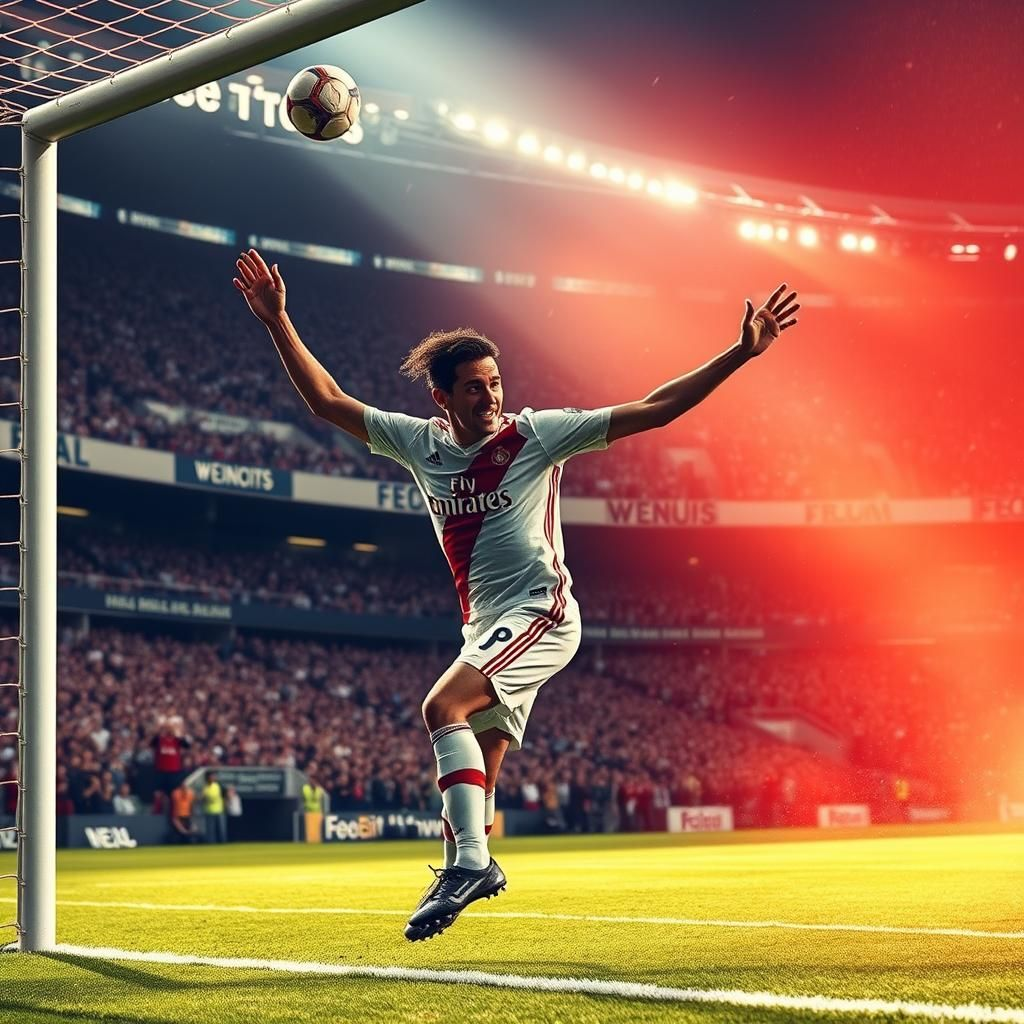

In [16]:
image = requests.get(image_response.data[0].url)
txt_filename = txt_filename.split('\n')[0]

if image.status_code == 200:
    with open(f'{txt_filename}.jpg', 'wb') as file:
        file.write(image.content)
    image = image.content
    
else:
    image_gen = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
    ).to("mps")

    image = image_gen(prompt=image_prompt_respone).images[0]
    image.save(f"{txt_filename}.jpg")
    
with open(f'{txt_filename}.txt', 'w') as file:
    file.write(txt_file_write)
    
Image(image)